In [22]:
import os
import cv2
from transformers import pipeline
from PIL import Image
import requests
import numpy as np
from tqdm import tqdm

In [23]:
# ================= Dataset config values =================

histogram_threshold = 1500
dataset_output_name = "dataset-full"

# =========================================================

In [24]:
# load pipe
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")

In [25]:
data_folder = "./data/"
existing_image_folder = "existing_data/"
existing_image_sub_folders = [
    "cyberzoo_aggressive_flight/20190121-144646/",
    "cyberzoo_canvas_approach/20190121-151448/",
    "cyberzoo_poles/20190121-135009/",
    "cyberzoo_poles_panels/20190121-140205/",
    "cyberzoo_poles_panels_mats/20190121-142935/",
]

collected_image_folder = "collected_data/"
collected_image_sub_folders = os.listdir(data_folder + collected_image_folder)

In [26]:
all_images = []
all_folders = []
all_folders.extend([data_folder + existing_image_folder + sub_folder for sub_folder in existing_image_sub_folders])
all_folders.extend([data_folder + collected_image_folder + sub_folder for sub_folder in collected_image_sub_folders])

for fol in all_folders:
    print(f"Collecting images from: {fol}")
    images = [(fol + img) for img in os.listdir(fol) if img.endswith(".jpg")]
    all_images.extend(images)

In [27]:
print(f"Total numer of image files: {len(all_images)}")

Total numer of image files: 10633


In [39]:
# Reduce dataset size for testing
# all_images = all_images[:5]

In [29]:
def get_label(datapoint):
    # Calculate the histogram
    hist_values, bin_edges = np.histogram(datapoint.ravel(), bins=5, range=(0, 255))

    # Print the histogram values and bin edges
    new_label = hist_values[-1] > histogram_threshold
    return new_label

In [30]:
dataset_lst = []

# TODO: This code does not properly utilize the GPU, this is due to the pipeline used
# This causes the model to take much longer than necessary to process the dataset

for img_file in tqdm(all_images):
    # Open image
    image = Image.open(img_file)

    image = image.rotate(90, expand=True) # All images are vertical, rotate them to be horizontal
    
    # Calculate depth for entire image
    depth = pipe(image)["depth"]
    
    # Crop the 3 image patches from the depth
    # Patches are collected as 170x170 images, are later on reduced to 85x85
    img1_d = np.asarray(depth.crop((0, 35, 170, 205)))
    img2_d = np.asarray(depth.crop((170, 35, 340, 205)))
    img3_d = np.asarray(depth.crop((340, 35, 510, 205)))

    # Crop the 3 image patches from the RGB image
    img1 = image.crop((0, 35, 170, 205))
    img2 = image.crop((170, 35, 340, 205))
    img3 = image.crop((340, 35, 510, 205))

    # Get the label based on the depth
    lbl1 = get_label(img1_d)

    datadct1 = {
        "filename": img_file,
        "depth": img1_d,
        "image": img1,
        "label": lbl1
    }

    # Get the label based on the depth
    lbl2 = get_label(img2_d)

    datadct2 = {
        "filename": img_file,
        "depth": img2_d,
        "image": img2,
        "label": lbl2
    }

    # Get the label based on the depth
    lbl3 = get_label(img3_d)

    datadct3 = {
        "filename": img_file,
        "depth": img3_d,
        "image": img3,
        "label": lbl3
    }

    # Store each patch as its own datapoint
    dataset_lst.append(datadct1)
    dataset_lst.append(datadct2)
    dataset_lst.append(datadct3)


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


In [31]:
print(f"Total dataset size {len(dataset_lst)}")
# Dataset is quite imbalanced
print(f"Number of true labels {len([x for x in dataset_lst if x['label'] == True])}")

Total dataset size 15
Number of true labels 4


False


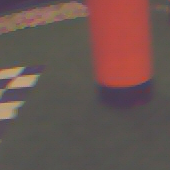

In [36]:
# Inspect an image
i = 10
print(dataset_lst[i]['label'])
dataset_lst[i]['image']

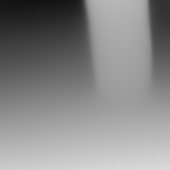

In [37]:
# Show depth
Image.fromarray(np.uint8(dataset_lst[i]['depth']))

In [38]:
import pickle

# Save dataset as pickle
with open(dataset_output_name + '.pkl', 'wb') as f:
    pickle.dump(dataset_lst, f)